In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import air_traff_utils as atu
from sklearn import preprocessing

import ipdb

In [2]:
atu.setup_seed(12)

In [3]:
def plot_tensor_quick(tensor):
#     plt.figure()
    try:
        plt.plot(tensor.cpu().detach().numpy())
    except Exception as e:
        plt.plot(tensor.detach().numpy())

# Loading Data

In [4]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [5]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [6]:
data_X = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'INTPTLAT', 'INTPTLON', 'geometry', 'if_plot'], axis=1))
data_X.index = range(data_X.shape[0])


In [7]:
data_X['CSA_Code'] = ''
for i in data_X.index:
    CSA_Name = data_X.loc[i, 'CSA_Name']
    data_X.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

print(data_X.shape)
data_X.head(2)

(24, 20)


,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,CSA_Name,CSA_Code
0,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,5.484528,18.586822,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


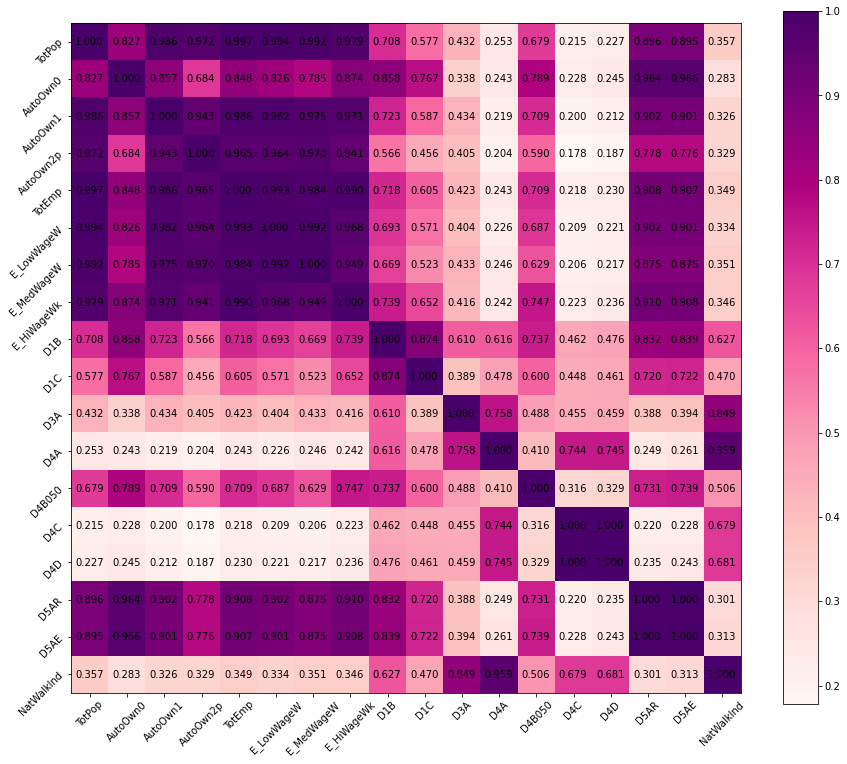

In [8]:
plt.figure(figsize=[15,15])
heat_plot_data_X = data_X.iloc[:, :18]
plt.imshow(heat_plot_data_X.corr(), cmap='RdPu')
for i in range(18):  # 18 features, number may subject to change
    for j in range(18):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X.corr().iloc[i, j]))
plt.xticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.yticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.colorbar(shrink=0.85)

(24, 24)


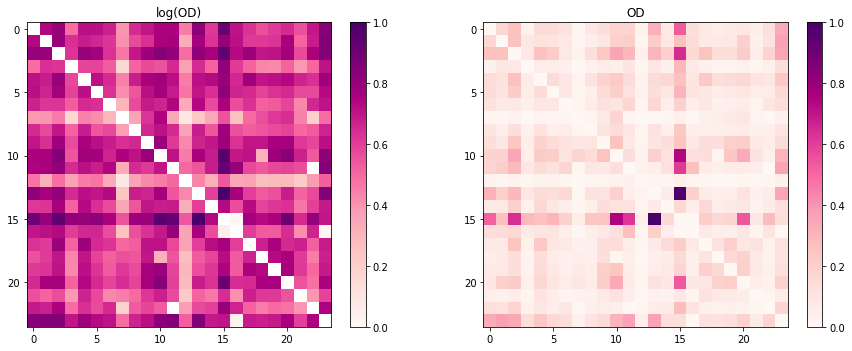

In [9]:
print(OD.shape)
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(121)
ax1.imshow(np.log(OD), cmap='RdPu')
ax1.set_title('log(OD)')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(122)
ax2.imshow(OD, cmap='RdPu')
ax2.set_title('OD')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax2, shrink=0.8)


# Prepare Feature Pairs
## For each OD pair in the OD matrix, it has its feature combination, [feature of loc1, feature of loc2, distance]

In [10]:
def GCDistance(S_Lat,S_Lon,E_Lat,E_Lon):
    start_lat = np.radians(S_Lat)  
    start_lon = np.radians(S_Lon)
    end_lat = np.radians(E_Lat)
    end_lon = np.radians(E_Lon)
    d_lat = end_lat - start_lat  
    d_lon = end_lon - start_lon  
    a = np.sin(d_lat/2)**2 + np.cos(start_lat) * np.cos(end_lat) * np.sin(d_lon/2)**2  
    c = 2 * np.arcsin(np.sqrt(a))  
    # Radius of earth is 3440 nm
    return 3440 * c

In [11]:
def get_data_X_OD(data_X):
    num_cities = CSA_df.shape[0]
    data_X_OD = np.zeros([num_cities*num_cities, 18*2+1])  # 18 features, may subject to change
    for i in range(CSA_df.shape[0]):
        org = CSA_df.loc[i, 'Airport']
        S_Lat = CSA_df.loc[i, 'lat']
        S_Lon = CSA_df.loc[i, 'lon']
        for j in range(CSA_df.shape[0]):
            dest = CSA_df.loc[i, 'Airport']
            feature_org = data_X.loc[data_X['CSA_Code']==org].values.flatten()[:18]
            feature_dest = data_X.loc[data_X['CSA_Code']==dest].values.flatten()[:18]
            feature = np.append(feature_org, feature_dest)
            
            E_Lat = CSA_df.loc[j, 'lat']
            E_Lon = CSA_df.loc[j, 'lon']
            distance = GCDistance(S_Lat,S_Lon,E_Lat,E_Lon)  # Great Circle Distance, unit: [nm]
            
            data_X_OD[i*num_cities+j, :] = np.append(feature, distance)
        
    # preprocessing.StandardScaler(), see:
    # https://scikit-learn.org/stable/modules/preprocessing.html
    scalar = preprocessing.StandardScaler().fit(data_X_OD)
    data_X_OD_norm = scalar.transform(data_X_OD)
    
    return scalar, data_X_OD_norm


In [12]:
scalar_data_X, data_X_OD = get_data_X_OD(data_X)  # shape: [num_cities * num_cities, num_features*2+1]
print('data_X_OD | Shape:', data_X_OD.shape, ', type: %s'%type(data_X_OD))
std_vec = data_X_OD.std(axis=0)
print('std_vec | Shape:', std_vec.shape, ', type: %s'%type(std_vec))
# ################# NOTE ####################
# this OD is logged
OD = np.array(OD)
for i in range(OD.shape[0]):
    for j in range(OD.shape[1]):
        if OD[i, j]!=0:
            OD[i, j] = np.log(OD[i, j])
OD = OD.reshape(-1, 1)  # shape: [num_cities * num_cities, 1]

print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

data_X_OD | Shape: (576, 37) , type: <class 'numpy.ndarray'>
std_vec | Shape: (37,) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


# Define VAE Model Structure

In [13]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [61]:
# Model specification
class VAE_FC_Net(nn.Module):
    def __init__(self, in_out_size, feature_dim=18+18+1, dropout_p=0.0):
        super(VAE_FC_Net, self).__init__()
        self.in_out_size = in_out_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder1 = nn.Sequential(
            nn.Linear(in_out_size, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(in_out_size, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, in_out_size),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        # shape of x: [batch, ]
#         ipdb.set_trace()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # shape of "x" here = [batch, feature_dim]
        hidden_mean = self.encoder1(x)
        hidden_std = self.encoder2(x)
        
        hidden_mean = nn.BatchNorm1d(hidden_mean.shape[1], device=device)(hidden_mean)
        hidden_std = nn.BatchNorm1d(hidden_std.shape[1], device=device)(hidden_std)
        
        # sampling process
        gaussian_noise = torch.normal(
            torch.normal(torch.zeros(self.feature_dim), torch.ones(self.feature_dim))
        ).view(-1, self.feature_dim).to(device)
        sampled_feature = hidden_mean + hidden_std*gaussian_noise
        
        y = self.decoder(sampled_feature)  # vae
        y = self.decoder(hidden_mean)  # ae
        return hidden_mean, hidden_std, y
    

# Preparing data for PyTorch

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OD = torch.tensor(OD, dtype=torch.float32, device=device, requires_grad=True)
data_X_OD = torch.tensor(data_X_OD, dtype=torch.float32, device=device, requires_grad=True)
std_vec = torch.tensor(std_vec, dtype=torch.float32, device=device, requires_grad=True)
std = std_vec.repeat([576, 1])

# batch_size = 1024
# loader_train = torch.utils.data.DataLoader(
#     TensorDataset(OD, data_X_OD), batch_size, shuffle=False
# )

# iter_train = iter(loader_train)

C:\Users\10169\AppData\Local\Temp/ipykernel_13328/4214812398.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  OD = torch.tensor(OD, dtype=torch.float32, device=device, requires_grad=True)
C:\Users\10169\AppData\Local\Temp/ipykernel_13328/4214812398.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_X_OD = torch.tensor(data_X_OD, dtype=torch.float32, device=device, requires_grad=True)
C:\Users\10169\AppData\Local\Temp/ipykernel_13328/4214812398.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_vec = torch.tensor(std_vec, dty

## Define KL Divergence between two Gaussian Distributions
<img src="./imgs/KL.png" width="500">
Note that $\sigma_2=1$

In [63]:
def KL_loss(mean1, std1, mean2):
    # mean1, std1, mean2, std2 are 2-D matrices (type: tensor)
    # the first dimension is batch size, 
    # the second is number of variables
    
    # mean1, std1 are mean, std of predicted value
    # mean2, std2 are mean, std of true value, std2=1
    # 1 and 2 are irreversible
    
    assert mean1.shape[0] == mean2.shape[0]
    assert mean1.shape[1] == mean2.shape[1]

    KL_div = -0.5*(torch.log(std1**2) - std1**2 - (mean1 - mean2)**2 + 1).sum(axis=1).mean()
    
    return KL_div  # depends on the reconstruction loss reduction (either sum or mean)

# Initialize the Model

In [64]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
model = VAE_FC_Net(in_out_size=1).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_recons = []
loss_set_KL = []
loss_set_train = []
loss_set_gen = []

print('There are %i OD pairs'%OD.shape[0])

There are 576 OD pairs


In [65]:
# summary(model) 

# Train the Model

In [66]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [76]:
model.train()
X = OD
hid_mean = data_X_OD

epochs = 10000
   
for e in range(epochs+1):
    #ipdb.set_trace()

    hidden_mean, hidden_std, out = model(X)
    hidden_std[abs(hidden_std-0)<1e-8] = .0001
    loss_re = loss_recon(out, X)
#     loss_KL = KL_loss(hidden_mean, hidden_std, hid_mean)
    loss_KL = ((hidden_mean - hid_mean)**2).sum(axis=1).mean()
    loss = loss_re + loss_KL

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e%50==0:

        out_gen = model.decoder(hid_mean)
#         ipdb.set_trace()
        loss_gen = loss_recon(out_gen, X)

        loss_set_gen.append(loss_gen.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
        loss_set_recons.append(loss_re.cpu().detach().numpy())
        loss_set_KL.append(loss_KL.cpu().detach().numpy())

        # print the information of epoch e, the last mini-batch
        print('Epoch %i   success, gen loss:%.6f, reconstruction loss:%.6f, KL loss:%.6f, '%(
            e, loss_gen.cpu().detach().numpy(), loss_re.cpu().detach().numpy(), loss_KL.cpu().detach().numpy()
        ))
        

Epoch 0   success, gen loss:76.400566, reconstruction loss:0.014384, KL loss:42.786125, 
Epoch 50   success, gen loss:76.254364, reconstruction loss:0.009608, KL loss:42.759365, 
Epoch 100   success, gen loss:76.111641, reconstruction loss:0.005798, KL loss:42.720596, 
Epoch 150   success, gen loss:75.998756, reconstruction loss:0.025355, KL loss:41.902832, 
Epoch 200   success, gen loss:76.272652, reconstruction loss:0.022406, KL loss:40.964077, 
Epoch 250   success, gen loss:76.623390, reconstruction loss:0.014771, KL loss:40.933071, 
Epoch 300   success, gen loss:76.866364, reconstruction loss:0.009929, KL loss:40.904591, 
Epoch 350   success, gen loss:77.072212, reconstruction loss:0.006900, KL loss:40.875713, 
Epoch 400   success, gen loss:77.090477, reconstruction loss:0.006412, KL loss:40.848446, 
Epoch 450   success, gen loss:76.974586, reconstruction loss:0.005176, KL loss:40.820408, 
Epoch 500   success, gen loss:76.784462, reconstruction loss:0.002806, KL loss:40.723499, 
Ep

Epoch 4500   success, gen loss:86.189468, reconstruction loss:0.796748, KL loss:41.520527, 
Epoch 4550   success, gen loss:87.150467, reconstruction loss:0.157390, KL loss:40.021656, 
Epoch 4600   success, gen loss:86.787704, reconstruction loss:0.043628, KL loss:40.017838, 
Epoch 4650   success, gen loss:86.313881, reconstruction loss:0.010720, KL loss:40.029240, 
Epoch 4700   success, gen loss:85.811943, reconstruction loss:0.125719, KL loss:39.941814, 
Epoch 4750   success, gen loss:85.299820, reconstruction loss:0.005112, KL loss:40.046291, 
Epoch 4800   success, gen loss:84.828957, reconstruction loss:0.133719, KL loss:39.870380, 
Epoch 4850   success, gen loss:85.660881, reconstruction loss:0.288491, KL loss:42.559559, 
Epoch 4900   success, gen loss:85.834305, reconstruction loss:0.029128, KL loss:41.074524, 
Epoch 4950   success, gen loss:85.640945, reconstruction loss:0.014229, KL loss:39.971180, 
Epoch 5000   success, gen loss:85.354912, reconstruction loss:0.019389, KL loss:

Epoch 9000   success, gen loss:75.515823, reconstruction loss:0.003977, KL loss:39.020069, 
Epoch 9050   success, gen loss:75.354454, reconstruction loss:0.003103, KL loss:39.017872, 
Epoch 9100   success, gen loss:75.197403, reconstruction loss:0.003101, KL loss:39.015076, 
Epoch 9150   success, gen loss:75.041084, reconstruction loss:0.002773, KL loss:39.012573, 
Epoch 9200   success, gen loss:74.884483, reconstruction loss:0.001886, KL loss:39.010532, 
Epoch 9250   success, gen loss:74.735596, reconstruction loss:0.002347, KL loss:39.006702, 
Epoch 9300   success, gen loss:74.563194, reconstruction loss:0.002451, KL loss:39.002117, 
Epoch 9350   success, gen loss:74.414696, reconstruction loss:0.001980, KL loss:38.995289, 
Epoch 9400   success, gen loss:74.245163, reconstruction loss:0.002414, KL loss:38.972630, 
Epoch 9450   success, gen loss:74.595253, reconstruction loss:0.136576, KL loss:41.985832, 
Epoch 9500   success, gen loss:74.755989, reconstruction loss:0.037188, KL loss:

In [80]:
def plot_loss(gen, train, recons, KL, title):
    fig = plt.figure(figsize=[16,5])
    ax1 = fig.add_subplot(141)
    ax1.plot(gen)
    ax1.set_xlabel('Epoches/50')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(gen)])
    ax1.set_title('Generation loss')
    ax1.grid()
    ax2 = fig.add_subplot(142)
    ax2.plot(train)
    ax2.set_xlabel('Epoches/50')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    ax3 = fig.add_subplot(143)
    ax3.plot(recons)
    ax3.set_xlabel('Epoches/50')
    ax3.set_ylabel('MSELoss')
    ax3.set_ylim([0, max(recons)])
    ax3.set_title('Reconstruction loss')
    ax3.grid()
    ax4 = fig.add_subplot(144)
    ax4.plot(KL)
    ax4.set_xlabel('Epoches/50')
    ax4.set_ylabel('MSELoss')
    ax4.set_ylim([0, max(KL)])
    ax4.set_title('KL loss')
    ax4.grid()
    
    plt.suptitle(title)

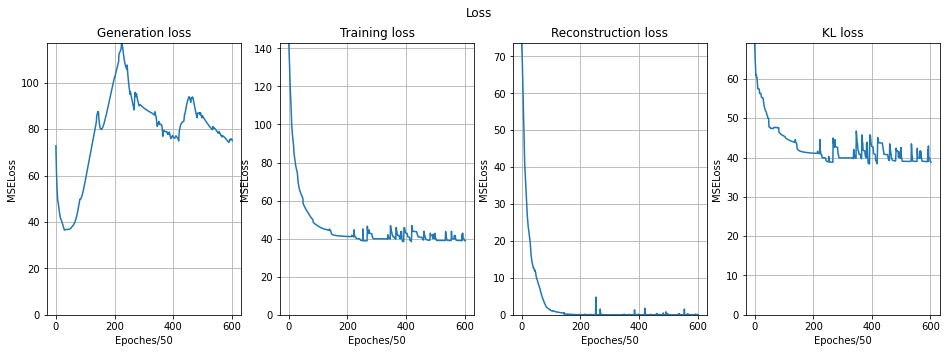

In [81]:
plot_loss(loss_set_gen, loss_set_train, loss_set_recons, loss_set_KL, 'Loss')

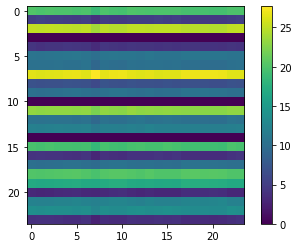

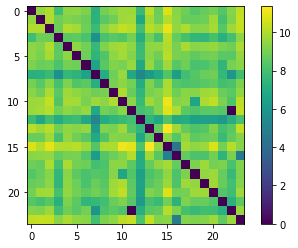

In [82]:
plt.figure()
plt.imshow(out_gen.cpu().detach().numpy().reshape(24,24))
plt.colorbar()
plt.figure()
plt.imshow(X.cpu().detach().numpy().reshape(24,24))
plt.colorbar()